In [ ]:
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import random
seed(2)
import tensorflow as tf
tf.random.set_seed(2)
#set_random_seed(2)

import cv2
from glob import glob

from sklearn.metrics import classification_report, confusion_matrix

#from keras.utils import print_summary
from tensorflow.keras import Model, Sequential
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from pathlib import Path
import pandas as pd
import numpy as np
from os import getenv
import time
import itertools

from skimage.filters import sobel, scharr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/Com_BdSL/train"
TEST_DIR = "/content/drive/MyDrive/Com_BdSL/test"

classes = [folder[len(TRAIN_DIR)+ 1 :] for folder in glob(TRAIN_DIR + '/*')]
classes.sort()

In [ ]:
target_size = (128,128)
target_dims = (128,128,3)
N_classes = 36
validation_split = 0.1
batch_size = 64

In [ ]:
MODEL_DIR = '/content/drive/MyDrive/Com_BdSL/BdSL_CNN_Model'
MODEL_PATH = MODEL_DIR + '/cnn-model.h5'
MODEL_WEIGHTS_PATH = MODEL_DIR + '/cnn-model.weights.h5'
MODEL_SAVE_TO_DISK = getenv('KAGGLE_WORKING_DIR') != '/kaggle/working'

print('Save model to disk? {}'.format('Yes' if MODEL_SAVE_TO_DISK else 'No'))

Save model to disk? Yes


In [ ]:
def plot_one_sample_of_each(base_path):
    cols = 6
    rows = int(np.ceil(len(classes) / cols))
    fig = plt.figure(figsize=(16, 20))

    for i in range(len(classes)):
        cls = classes[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)

        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

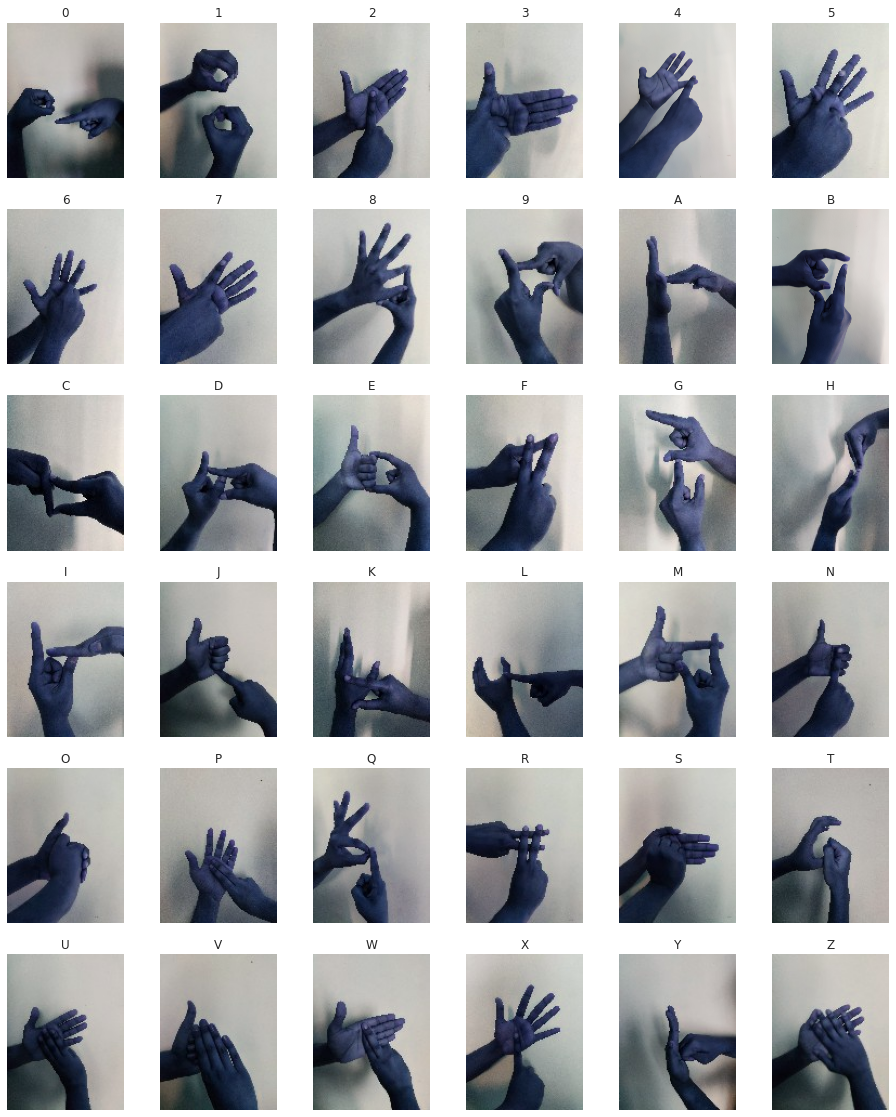

In [ ]:
plot_one_sample_of_each(TRAIN_DIR)

Here,
ঃ = 1,
অ = 2,
আ = 3,
ই = 4,
উ = 5,
এ = 6,
ও = 7,
ক = 8,
খ = 9,
গ = A,
ঘ = B,
চ = C,
ছ = D,
জ = E,
ঝ = F,
ট = G,
ঠ = H,
ড = I,
ড় = J,
ঢ = K,
ত = L,
থ = M,
দ = N,
ধ = O,
ন = P,
প = Q,
ফ = R,
ব = S,
ভ = T,
ম = U,
য় = V,
র = W,
ল = X,
স = Y,
হ = Z

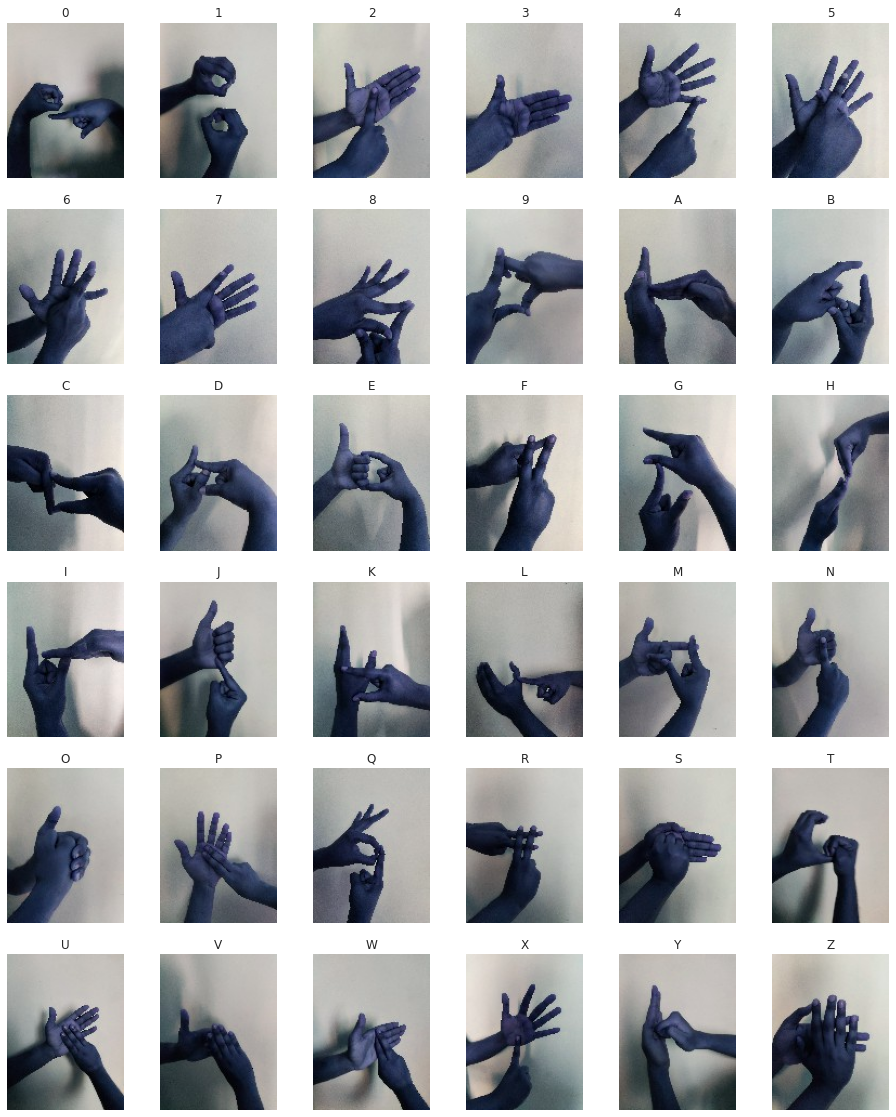

In [ ]:
plot_one_sample_of_each(TEST_DIR)

In [ ]:
def preprocess_image(image):
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    return sobely

def make_generator(options):
    validation_split = options.get('validation_split', 0.0)
    preprocessor = options.get('preprocessor', None)
    data_dir = options.get('data_dir', TRAIN_DIR)

    augmentor_options = {
        'samplewise_center': True,
        'samplewise_std_normalization': True,
    }
    if validation_split is not None:
        augmentor_options['validation_split'] = validation_split

    if preprocessor is not None:
        augmentor_options['preprocessing_function'] = preprocessor

    flow_options = {
        'target_size': target_size,
        'batch_size': batch_size,
        'shuffle': options.get('shuffle', None),
        'subset': options.get('subset', None),
    }

    data_augmentor = ImageDataGenerator(**augmentor_options)
    return data_augmentor.flow_from_directory(data_dir, **flow_options)

In [ ]:
def load_model_from_disk():
    model_file = Path(MODEL_PATH)
    model_weights_file = Path(MODEL_WEIGHTS_PATH)

    if model_file.is_file() and model_weights_file.is_file():
        print('Retrieving model from disk...')
        model = load_model(model_file.__str__())

        print('Loading CNN model weights from disk...')
        model.load_weights(model_weights_file)
        return model

    return None

CNN_MODEL = load_model_from_disk()
REPROCESS_MODEL = (CNN_MODEL is None)

print('Need to reprocess? {}'.format(REPROCESS_MODEL))

Need to reprocess? True


In [ ]:
def build_model(save = False):

    print('Building model afresh...')

    model = Sequential()

    model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=target_dims))
    model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(N_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    if save: model.save(MODEL_PATH)

    return model

if REPROCESS_MODEL:
    CNN_MODEL = build_model(save=MODEL_SAVE_TO_DISK)

Model.summary(CNN_MODEL)

Building model afresh...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        65600     
                                                                 
 dropout (Dropout)           (None, 61, 61, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 128)       131200    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       262272    
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (N

In [ ]:
def make_generator_for(subset):
    generator_options = dict(
        validation_split=validation_split,
        shuffle=True,
        subset=subset,
        preprocessor=preprocess_image,
    )
    return make_generator(generator_options)


def fit_model(model, train_generator, val_generator, save=False):
    history = model.fit_generator(train_generator, epochs=5, validation_data=val_generator)

    if save: model.save_weights(MODEL_WEIGHTS_PATH)

    return history


CNN_TRAIN_GENERATOR = make_generator_for('training')
CNN_VAL_GENERATOR = make_generator_for('validation')

HISTORY = None
if REPROCESS_MODEL:
    start_time = time.time()
    HISTORY = fit_model(CNN_MODEL, CNN_TRAIN_GENERATOR, CNN_VAL_GENERATOR, save=MODEL_SAVE_TO_DISK)
    print('Fitting the model took ~{:.0f} second(s).'.format(time.time() - start_time))


columns=['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']
pd.DataFrame(data=[x.shape for x in CNN_MODEL.weights], columns=columns)

Found 3413 images belonging to 36 classes.
Found 360 images belonging to 36 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/5
54/54 [==============================] - 1825s 34s/step - loss: 1.9402 - accuracy: 0.4749 - val_loss: 0.5606 - val_accuracy: 0.8333
Epoch 2/5
54/54 [==============================] - 590s 11s/step - loss: 0.2239 - accuracy: 0.9326 - val_loss: 0.5337 - val_accuracy: 0.8889
Epoch 3/5
54/54 [==============================] - 585s 11s/step - loss: 0.0808 - accuracy: 0.9745 - val_loss: 0.5734 - val_accuracy: 0.8806
Epoch 4/5
54/54 [==============================] - 583s 11s/step - loss: 0.0520 - accuracy: 0.9854 - val_loss: 0.3070 - val_accuracy: 0.9167
Epoch 5/5
54/54 [==============================] - 582s 11s/step - loss: 0.0561 - accuracy: 0.9845 - val_loss: 0.3998 - val_accuracy: 0.8583
Fitting the model took ~4335 second(s).


,Dimension 1,Dimension 2,Dimension 3,Dimension 4
0,4,4.0,3.0,64.0
1,64,NaN,NaN,NaN
2,4,4.0,64.0,64.0
3,64,NaN,NaN,NaN
4,4,4.0,64.0,128.0
5,128,NaN,NaN,NaN
6,4,4.0,128.0,128.0
7,128,NaN,NaN,NaN
8,4,4.0,128.0,256.0
9,256,NaN,NaN,NaN


In [ ]:
if HISTORY:
    print('Final Accuracy: {:.2f}%'.format(HISTORY.history['accuracy'][4] * 100))
    print('Validation set accuracy: {:.2f}%'.format(HISTORY.history['val_accuracy'][4] * 100))

Final Accuracy: 98.45%
Validation set accuracy: 85.83%


In [ ]:
def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.cividis):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(16, 16))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

In [ ]:
def evaluate_model(generator):
    start_time = time.time()
    evaluations = CNN_MODEL.evaluate_generator(generator)
    for i in range(len(CNN_MODEL.metrics_names)):
        print("{}: {:.2f}%".format(
            CNN_MODEL.metrics_names[i], evaluations[i] * 100))
    print('Took {:.0f} seconds to evaluate this set.'.format(
        time.time() - start_time))

    start_time = time.time()
    predictions = CNN_MODEL.predict_generator(generator)
    print('Took {:.0f} seconds to get predictions on this set.'.format(
        time.time() - start_time))

    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    return dict(y_pred=y_pred, y_true=y_true)


def evaluate_validation_dataset():
    gen_options = dict(
        validation_split=0.1,
        data_dir=TRAIN_DIR,
        shuffle=False,
        subset='validation',
        preprocessor=preprocess_image,
    )
    val_gen = make_generator(gen_options)
    return evaluate_model(val_gen)


def evaluate_test_dataset():
    gen_options = dict(
        validation_split=0.0,
        data_dir= TEST_DIR,
        shuffle=False,
        preprocessor=preprocess_image,
    )
    test_gen = make_generator(gen_options)
    return evaluate_model(test_gen)

In [ ]:
CNN_VALIDATION_SET_EVAL = evaluate_validation_dataset()

Found 360 images belonging to 36 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


loss: 39.98%
accuracy: 85.83%
Took 15 seconds to evaluate this set.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Took 21 seconds to get predictions on this set.


In [ ]:
print(classification_report(**CNN_VALIDATION_SET_EVAL, target_names=classes))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.90      0.95        10
           2       0.56      0.90      0.69        10
           3       1.00      0.30      0.46        10
           4       1.00      0.90      0.95        10
           5       1.00      1.00      1.00        10
           6       1.00      0.50      0.67        10
           7       0.67      1.00      0.80        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
           A       1.00      1.00      1.00        10
           B       1.00      1.00      1.00        10
           C       1.00      0.80      0.89        10
           D       1.00      1.00      1.00        10
           E       1.00      1.00      1.00        10
           F       1.00      0.40      0.57        10
           G       1.00      1.00      1.00        10
           H       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization


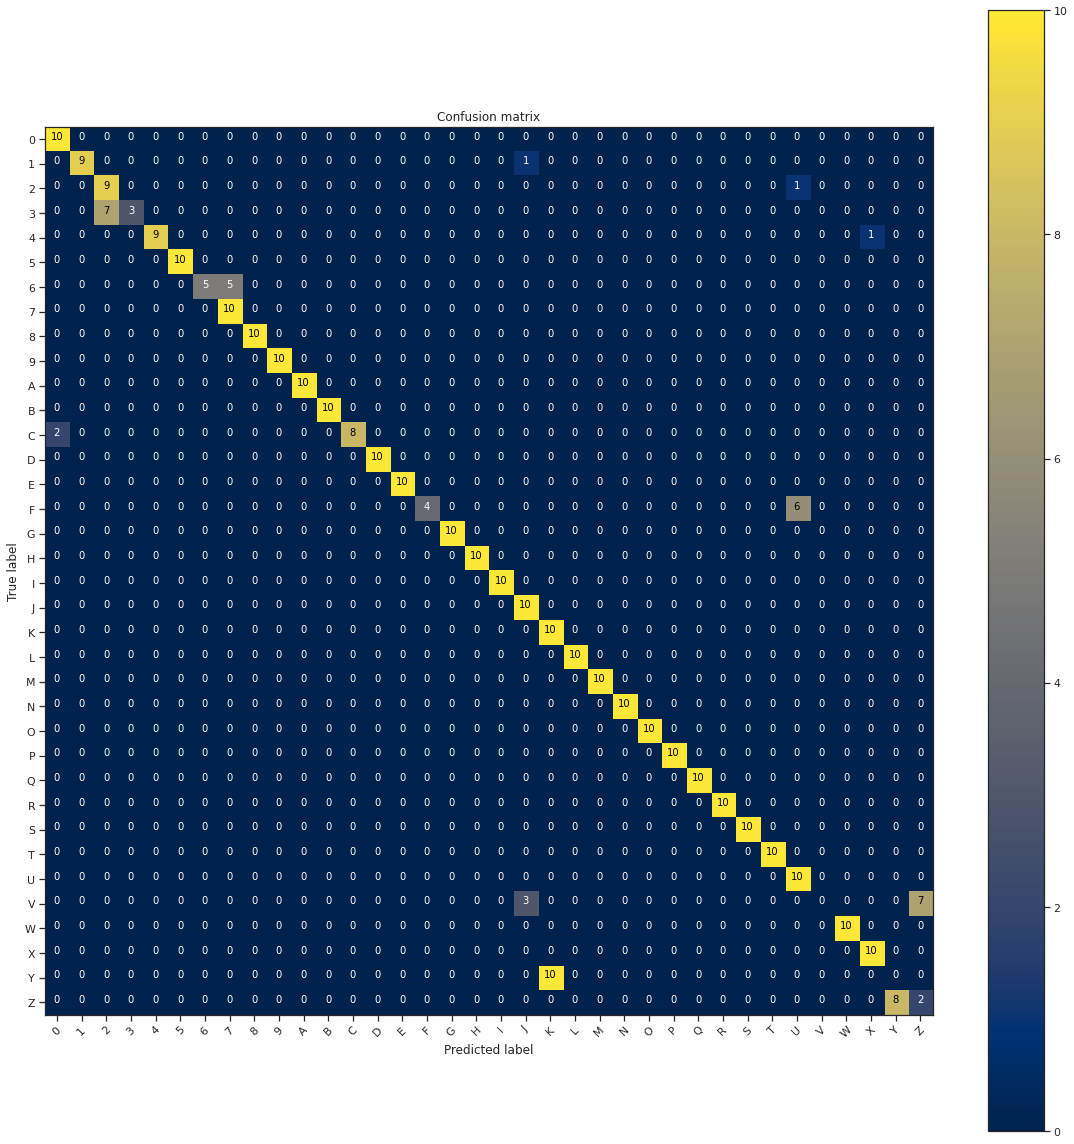

In [ ]:
with sns.axes_style('ticks'):
    plot_confusion_matrix_with_default_options(**CNN_VALIDATION_SET_EVAL, classes=classes)

In [ ]:
CNN_TEST_SET_EVAL = evaluate_test_dataset()

Found 362 images belonging to 36 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


loss: 5.62%
accuracy: 99.17%
Took 13 seconds to evaluate this set.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Took 13 seconds to get predictions on this set.


In [ ]:
print(classification_report(**CNN_TEST_SET_EVAL, target_names=classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       1.00      0.90      0.95        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      0.90      0.95        10
           7       0.91      1.00      0.95        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
           A       1.00      1.00      1.00        10
           B       1.00      0.90      0.95        10
           C       1.00      1.00      1.00        10
           D       1.00      1.00      1.00        10
           E       1.00      1.00      1.00        10
           F       1.00      1.00      1.00        10
           G       1.00      1.00      1.00        10
           H       1.00    

Confusion matrix, without normalization


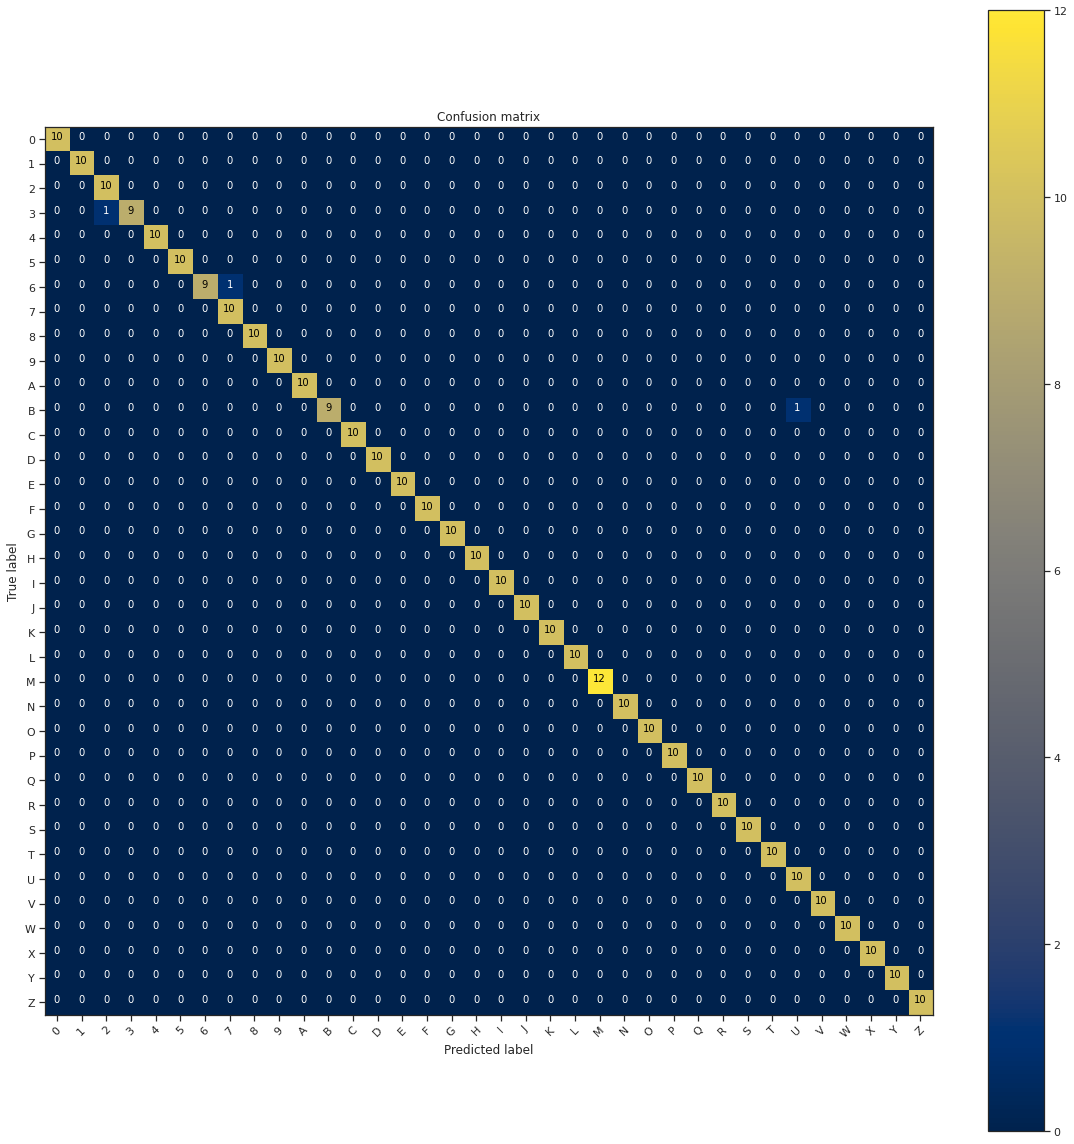

In [ ]:
with sns.axes_style('ticks'):
    plot_confusion_matrix_with_default_options(**CNN_TEST_SET_EVAL, classes=classes)

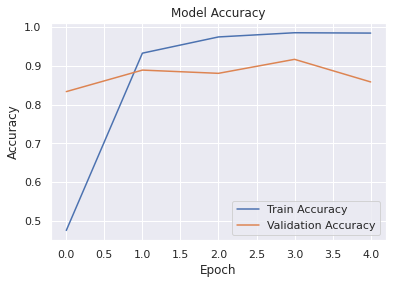

In [ ]:
plt.plot(HISTORY.history['accuracy'])
plt.plot(HISTORY.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy", "Validation Accuracy"], loc = 'lower right')
plt.show()

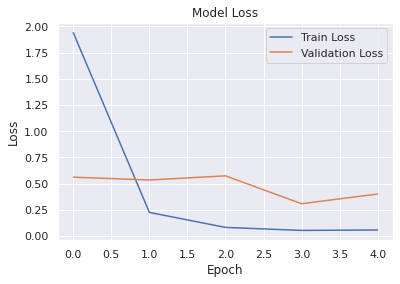

In [ ]:
plt.plot(HISTORY.history['loss'])
plt.plot(HISTORY.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss", "Validation Loss"], loc = 'upper right')
plt.show()

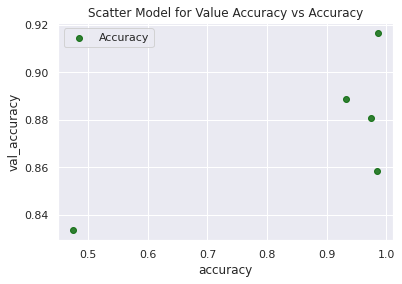

In [ ]:
plt.scatter(HISTORY.history['accuracy'], HISTORY.history['val_accuracy'],
            label = 'Accuracy', color='darkgreen', alpha=0.8, marker= 'o')
plt.ylabel('val_accuracy')
plt.xlabel('accuracy')
plt.title('Scatter Model for Value Accuracy vs Accuracy')
plt.legend(loc='upper left')
plt.show()

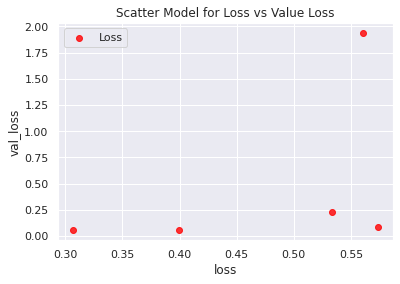

In [ ]:
plt.scatter(HISTORY.history['val_loss'], HISTORY.history['loss'],
            label = 'Loss', color='red', alpha=0.8, marker= 'o')
plt.ylabel('val_loss')
plt.xlabel('loss')
plt.title('Scatter Model for Loss vs Value Loss')
plt.legend(loc='upper left')
plt.show()

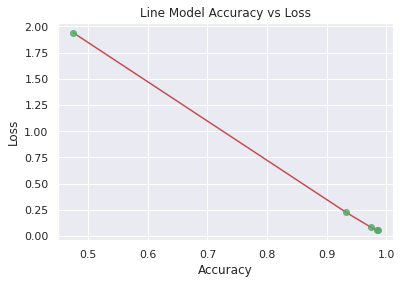

In [ ]:
plt.plot(HISTORY.history['accuracy'], HISTORY.history['loss'],'r-')
plt.plot(HISTORY.history['accuracy'], HISTORY.history['loss'],'go', alpha=0.8)
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.title('Line Model Accuracy vs Loss')
plt.show()

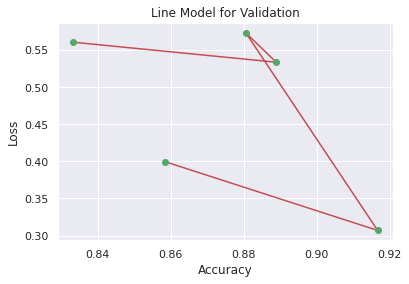

In [ ]:
plt.plot(HISTORY.history['val_accuracy'], HISTORY.history['val_loss'],'r-')
plt.plot(HISTORY.history['val_accuracy'], HISTORY.history['val_loss'],'go')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.title('Line Model for Validation')
plt.show()